In [1]:
url1 = "https://raw.githubusercontent.com/Luchkata/Algorithmic_Trading_Machine_Learning/refs/heads/main/simulated_daily_data.csv"

In [2]:
url2 = "https://raw.githubusercontent.com/Luchkata/Algorithmic_Trading_Machine_Learning/refs/heads/main/simulated_5min_data.csv"

In [3]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np
import os


In [4]:
import pandas_ta 

In [5]:
daily_df = pd.read_csv(url1)

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(url2)

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


Parte que más demora y se va a paralelizar:

In [6]:
import time
""" start = time.time()
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x)) 

daily_df = daily_df.dropna()

daily_df 

fin = time.time()
print("Tiempo de ejecución:", fin - start, "segundos") """

' start = time.time()\ndaily_df[\'log_ret\'] = np.log(daily_df[\'Adj Close\']).diff()\n\ndaily_df[\'variance\'] = daily_df[\'log_ret\'].rolling(180).var()\n\ndaily_df = daily_df[\'2020\':]\n\ndef predict_volatility(x):\n\n    best_model = arch_model(y=x,\n                            p=1,\n                            q=3).fit(update_freq=5,\n                                     disp=\'off\')\n\n    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]\n\n    print(x.index[-1])\n\n    return variance_forecast\n\ndaily_df[\'predictions\'] = daily_df[\'log_ret\'].rolling(180).apply(lambda x: predict_volatility(x)) \n\ndaily_df = daily_df.dropna()\n\ndaily_df \n\nfin = time.time()\nprint("Tiempo de ejecución:", fin - start, "segundos") '

# Paralelización con Ray:

In [8]:
import ray
# Reiniciar Ray
ray.shutdown()
ray.init()

start = time.time()

# Calcular log-retornos y varianza histórica
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()
daily_df['variance'] = daily_df['log_ret'].rolling(180).var()
daily_df = daily_df['2020':]

# --- FUNCIÓN REMOTA RAY ---
@ray.remote
def predict_volatility_ray(index, x):
    best_model = arch_model(y=x, p=1, q=3).fit(update_freq=5, disp='off')
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1, 0]
    return index, variance_forecast

# Crear ventanas y asociar a su índice correspondiente
ventanas = [(daily_df.index[i], daily_df['log_ret'].iloc[i-179:i+1])
            for i in range(179, len(daily_df))]

# Filtrar ventanas válidas
ventanas = [(idx, win) for idx, win in ventanas if win.notnull().all() and np.all(np.isfinite(win))]

# Enviar cada ventana a Ray
futuros = [predict_volatility_ray.remote(idx, win) for idx, win in ventanas]

# Obtener resultados: lista de (fecha, predicción)
resultados = ray.get(futuros)

# Insertar las predicciones directamente al daily_df
for idx, pred in resultados:
    daily_df.at[idx, 'predictions'] = pred

# Limpiar filas con valores faltantes
daily_df = daily_df.dropna()

fin = time.time()
print("Tiempo de ejecución:", fin - start, "segundos")

2025-07-29 02:26:51,299	INFO worker.py:1567 -- Connecting to existing Ray cluster at address: 127.0.0.1:6379...
2025-07-29 02:26:51,310	INFO worker.py:1743 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
(predict_volatility_ray pid=18008) C:\Users\santi\Downloads\infraestructurasproyecto2\Infrastructura-Proyecto2\venv\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
(predict_volatility_ray pid=18008) estimating the model parameters. The scale of y is 0.002422. Parameter
(predict_volatility_ray pid=18008) estimation work better when this value is between 1 and 1000. The recommended
(predict_volatility_ray pid=18008) rescaling is 10 * y.
(predict_volatility_ray pid=18008) 
(predict_volatility_ray pid=18008) This warning can be disabled by either rescaling y before initializing the
(predict_volatility_ray pid=18008) model or by setting rescale=False.
(predict_volatility_ray pid

Tiempo de ejecución: 6.928851842880249 segundos


In [9]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-28,2262.115234,2299.386719,2243.881348,2285.895508,2285.895508,1.456087e+10,0.010797,0.002473,0.000728,-0.705554,NaN,NaN
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736673,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644688,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748336,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713828,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151791,0.528389,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240812,0.520501,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.520465,NaN


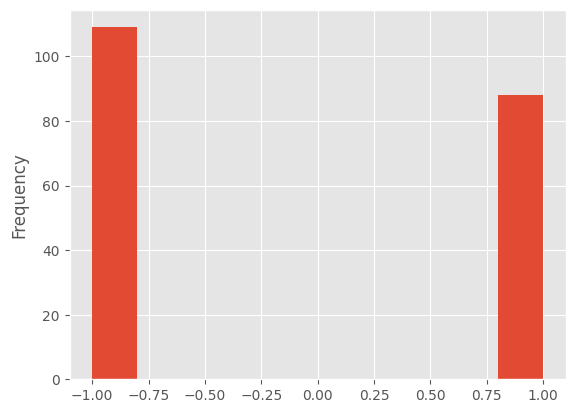

In [10]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

In [11]:
print(daily_df[['signal_daily']].reset_index().columns)


Index(['Date', 'signal_daily'], dtype='object')


In [12]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


In [13]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

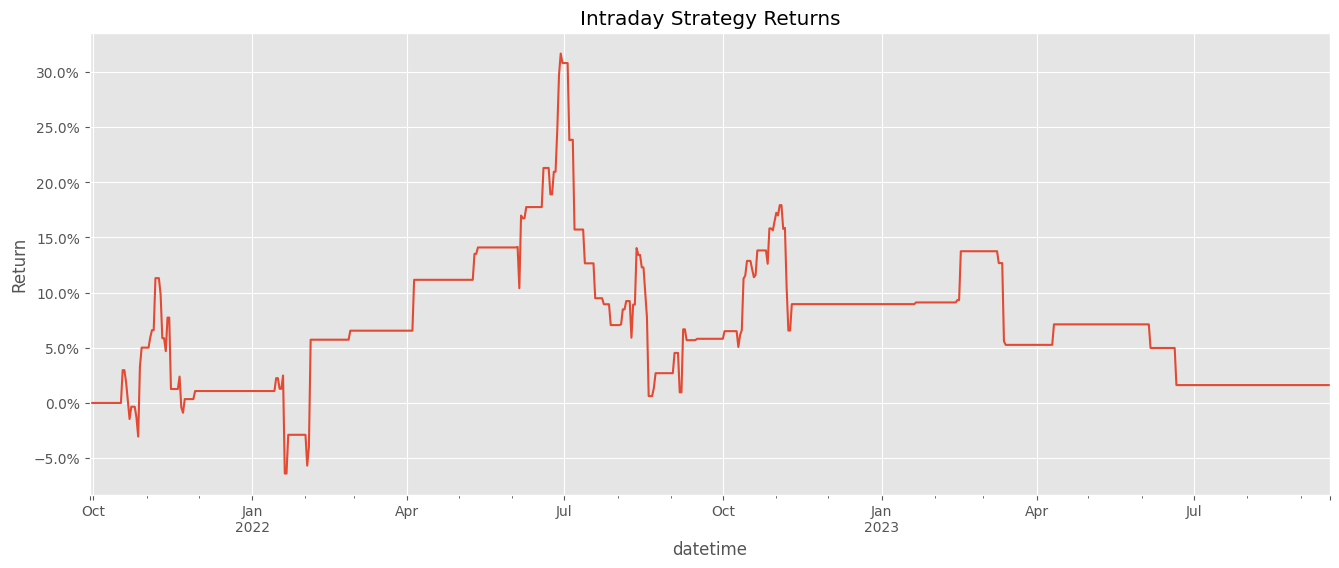

In [14]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
           

## Extraer datos para una prueba

In [15]:
import json

# Extraer los primeros 180 valores de log_ret desde 2020 en adelante
serie_real = daily_df['log_ret'].dropna().loc['2020':].iloc[:180].tolist()


fecha_real = daily_df['log_ret'].dropna().loc['2020':].iloc[179:].index[0].strftime("%Y-%m-%d")

entrada_json = {
    "serie": serie_real,
    "fecha": fecha_real
}

print(json.dumps(entrada_json, indent=4))


{
    "serie": [
        0.010796911263748932,
        0.005156696764797353,
        -0.005768117620406521,
        0.009836784773416873,
        -0.011433925019912472,
        -0.003965411962941978,
        0.0049599535112641036,
        -0.006431364706292797,
        0.032690363777000186,
        -0.01322747485481468,
        0.018849585047488127,
        -0.01607677289101428,
        9.051615736144214e-05,
        -0.004153644457159267,
        0.0039049160545205908,
        -0.00355135806493756,
        -4.3316029918472054e-05,
        -0.005465061685257844,
        -0.006614939571377931,
        0.0020964171092323625,
        0.0008353118250532532,
        0.002919331821293447,
        -0.0023526858330544798,
        0.022726572635563436,
        0.015923467226621746,
        0.005831453150000776,
        -0.004621806034724507,
        0.014595934904265029,
        0.023292897434799897,
        0.10400866610634907,
        -0.007126663308389958,
        0.017048706881663378,
     